This document is used for computing spatial compition in ecosystems to show phase-transition

In [106]:
import numpy as np
import matplotlib.pyplot as plt

The code below uses the Gaubler dynamics.

In [107]:
def initialize_lattice(n):
    """Initialize a 2D lattice with random spins of -1 or 1. Returns an n x n numpy array."""
    return np.random.choice([-1, 1], size=(n, n))

def random_sample_of_grid(grid):
    """Select a random cell from the grid and return its index."""
    rows = grid.shape[0]
    cols = grid.shape[1]

    random_i = np.random.randint(0, rows)
    random_j = np.random.randint(0, cols)
    index_of_sample = (random_i, random_j)

    return index_of_sample

def sum_of_sample_neighbours(grid, index_of_sample):
    """Calculate the sum of the neighbours of a given cell in the grid."""
    rows, cols = index_of_sample

    neighbour_left = grid[rows, (cols - 1) % grid.shape[1]]
    neighbour_right = grid[rows, (cols + 1) % grid.shape[1]]
    neighbour_up = grid[(rows - 1) % grid.shape[0], cols]
    neighbour_down = grid[(rows + 1)  % grid.shape[0], cols]

    total_sum_of_neighbours = neighbour_left + neighbour_right + neighbour_up + neighbour_down
    return total_sum_of_neighbours

def calculate_energy(neighbours_sum, H, J):
    """Calculate the energy contribution of a given cell in the grid."""
    energy_plus = - (H + J * neighbours_sum)
    energy_minus = H + J * neighbours_sum
    return energy_plus, energy_minus

def probability_up(energy_plus, energy_minus, temperature = 2.27):
    """Calculate the probability of a cell being in the +1 state."""
    beta = 1 / temperature
    p_up = np.exp(- beta * energy_plus) / (np.exp(-beta * energy_plus) + np.exp(-beta * energy_minus))
    return p_up

def monte_carlo(grid, index_of_sample, p_up):
    """probabilistically update the state of a cell in the grid based on p_up."""
    r = np.random.rand()
    if r < p_up:
        grid[index_of_sample] = 1
    else:
        grid[index_of_sample] = -1

Initialize parameters used for the simulation below.

In [108]:
size = 80
grid = initialize_lattice(size)

# Lists used for plotting later.
lenght_up = []
lenght_down = []

iter = 10000

Simulation of Gaubler dynamics

In [109]:
for i in range(iter):
    cell = random_sample_of_grid(grid)
    neighbours_sum = sum_of_sample_neighbours(grid, cell)
    energy = calculate_energy(neighbours_sum, H=0, J=1)
    p_up = probability_up(energy[0], energy[1], temperature=1)
    monte_carlo(grid, cell, p_up)
    lenght_up.append((grid == 1).sum())
    lenght_down.append((grid == - 1).sum())

Plotting

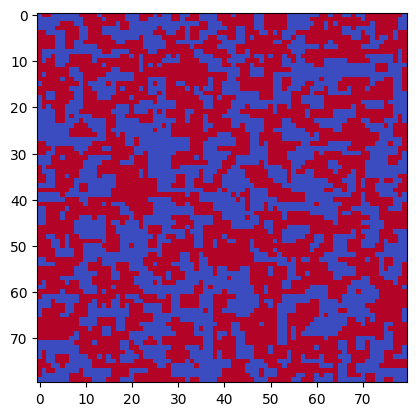

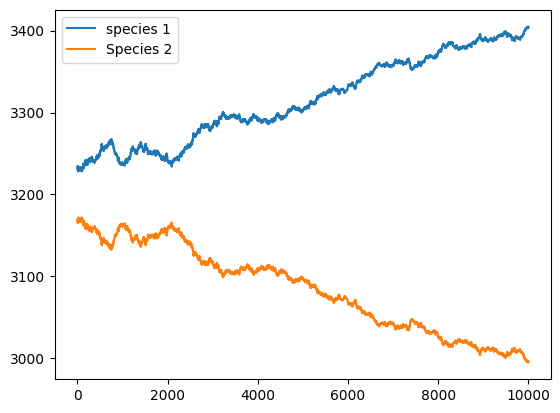

In [110]:
plt.imshow(grid, cmap='coolwarm')

fig, ax = plt.subplots()
x = np.linspace(0, iter, 10000)
ax.plot(x, lenght_up, label="species 1")
ax.plot(x, lenght_down, label="Species 2")
ax.legend()

As seen above the different colors represent different species. Note the different patches showing the seperation between the species

Lets know make it more realistic by instead of only spins by adding kawasaki dynamics.

In [111]:
def energy_change(grid, sum_neighbours, index_of_sample):
    """Calculate the change in energy if the spin at index_of_sample is flipped."""
    spin = grid[index_of_sample]
    delta_E = 2 * spin * sum_neighbours
    return delta_E

def neighbours(grid, index_of_sample):
    """Return the neighbours and their indices of a given cell in the grid. Boundary conditions are periodic."""
    rows, cols = index_of_sample

    neighbour_left = grid[rows, (cols - 1) % grid.shape[1]]
    index_left = (rows, (cols - 1) % grid.shape[1])

    neighbour_right = grid[rows, (cols + 1) % grid.shape[1]]
    index_right = (rows, (cols + 1) % grid.shape[1])

    neighbour_up = grid[(rows - 1) % grid.shape[0], cols]
    index_up = ((rows - 1) % grid.shape[0], cols)

    neighbour_down = grid[(rows + 1)  % grid.shape[0], cols]
    index_down = ((rows + 1)  % grid.shape[0], cols)

    return [neighbour_left, neighbour_right, neighbour_up, neighbour_down], [index_left, index_right, index_up, index_down]

def metropolis_rule(grid, index_of_sample, delta_E, T):
    """Apply the Metropolis rule to decide whether to flip the spin at index_of_sample."""
    if delta_E <= 0:
        grid[index_of_sample] = - grid[index_of_sample]

    else:
        u = np.random.rand()
        if u < np.exp(- delta_E / T):
            grid[index_of_sample] = - grid[index_of_sample]
    
    return grid

def kawasaki_dynamics(grid, index_of_sample):
    """Perform Kawasaki dynamics by swapping the spin at index_of_sample with a random neighbour."""
    neighbours_array = neighbours(grid, index_of_sample)
    random_index = np.random.randint(0, len(neighbours_array[0]))
    random_neigh = neighbours_array[0][random_index]
    random_neigh_index = neighbours_array[1][random_index]

    # Swap spins
    grid[index_of_sample], grid[random_neigh_index] = grid[random_neigh_index], grid[index_of_sample]  

    return grid

Initialize parameters

In [112]:
n = 100
N = n * n
T = 2

susceptibility_list = []
saved_grids = {}
p_list_plot = [0.1, 0.2, 0.4, 0.5]
p_dense = np.linspace(0.0, 0.55, 20)
p_list = np.unique(np.concatenate((p_list_plot, p_dense)))

Simulation

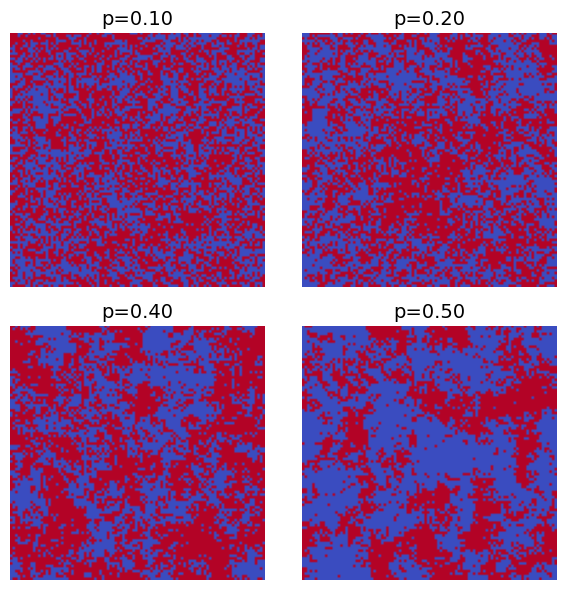

In [113]:
for p in p_list:

        grid = initialize_lattice(n)
        burn_in_steps = 250000 

        for _ in range(burn_in_steps):
                r = np.random.rand()
                if r < p:
                        sample = random_sample_of_grid(grid)
                        neighbours_sum = sum_of_sample_neighbours(grid, sample)
                        delta_E = energy_change(grid, neighbours_sum, sample)
                        grid = metropolis_rule(grid, sample, delta_E, T)
    
                else:
                        sample = random_sample_of_grid(grid)
                        grid = kawasaki_dynamics(grid, sample)
        
        measure_steps = 50000
        m_values = []
        m2_values = []
        
        for i in range(measure_steps):
                r = np.random.rand()
                if r < p:
                        sample = random_sample_of_grid(grid)
                        neighbours_sum = sum_of_sample_neighbours(grid, sample)
                        delta_E = energy_change(grid, neighbours_sum, sample)
                        grid = metropolis_rule(grid, sample, delta_E, T)
    
                else:
                        sample = random_sample_of_grid(grid)
                        grid = kawasaki_dynamics(grid, sample)

                if i % 10 == 0:
                        current_M = np.abs(np.sum(grid)) / N
                        m_values.append(current_M)
                        m2_values.append(current_M ** 2)
        
        avg_m = np.mean(m_values)
        avg_m2 = np.mean(m2_values)
        susceptibility = (N / T) * (avg_m2 - avg_m ** 2)
        susceptibility_list.append(susceptibility)


        if p in p_list_plot:
                saved_grids[p] = grid.copy()

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()

for i, p in enumerate(p_list_plot):
    if p in saved_grids:
        axs[i].imshow(saved_grids[p], cmap='coolwarm', aspect='equal')
        axs[i].set_title(f"p={p:.2f}", fontsize=14)
        axs[i].axis('off')

for j in range(len(p_list_plot), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

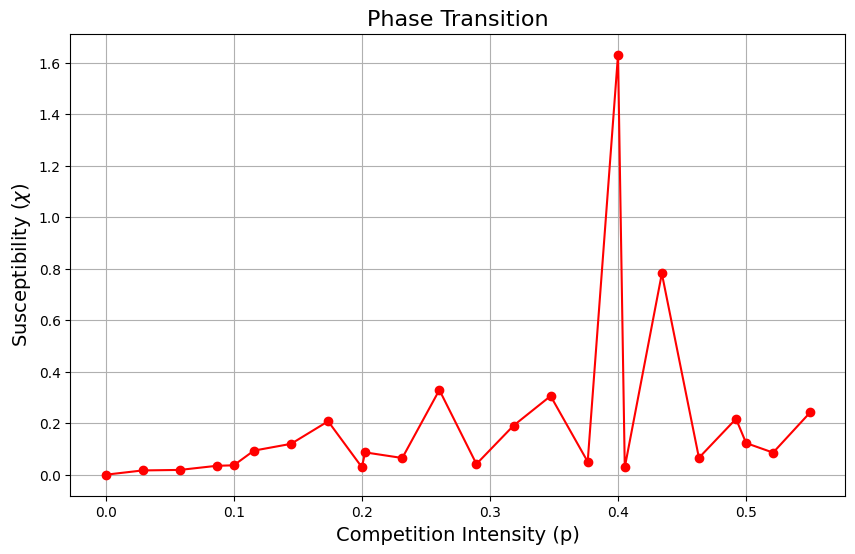

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(p_list, susceptibility_list, marker='o', linestyle='-', color='red')
plt.xlabel("Competition Intensity (p)", fontsize=14)
plt.ylabel(r"Susceptibility ($\chi$)", fontsize=14)
plt.title("Phase Transition", fontsize=16)
plt.grid(True)
plt.show()